In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
!pip install tweet-preprocessor
# !pip install catboost
# !pip install xgboost

In [19]:
import os

os.chdir('/content/gdrive/My Drive/CODE-MIXED-SENTI')
os.getcwd()

'/content/gdrive/My Drive/CODE-MIXED-SENTI'

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter


import preprocessor as p
p.set_options(p.OPT.EMOJI, p.OPT.SMILEY)
# p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.SMILEY, p.OPT.NUMBER)


cleaning = False

In [21]:
from imblearn.pipeline import Pipeline
from scipy.sparse import hstack, vstack

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:

train_data = pd.read_csv(os.path.join('data/tamil_train.tsv'), encoding='utf-8', sep='\t')
dev_data = pd.read_csv(os.path.join('data/tamil_dev.tsv'), encoding='utf-8', sep='\t')



In [27]:
train_data['text']=train_data['text'].str.title()
dev_data['text']=dev_data['text'].str.title()

In [28]:
if cleaning:
  text_ = pd.concat([train_data['text'], dev_data['text']])
  label_ = pd.concat([train_data['category'], dev_data['category']])
  text_ = text_.apply(lambda x: p.clean(x))
else:
  text_ = pd.concat([train_data['text'], dev_data['text']])
  label_ = pd.concat([train_data['category'], dev_data['category']])


In [29]:
print(train_text.head())

0             Trailer late ah parthavanga like podunga
1           Move pathutu vanthu trailer pakurvnga yaru
2             Puthupetai dhanush  ah yarellam pathinga
3     Dhanush oda character ,puthu sa erukay , mass ta
4     vera level ippa pesungada mokka nu thalaivaaaaaa
Name: text, dtype: object


Counter({'Positive ': 8484, 'Negative ': 1613, 'Mixed_feelings ': 1424, 'unknown_state ': 677, 'not-Tamil ': 397})


[]

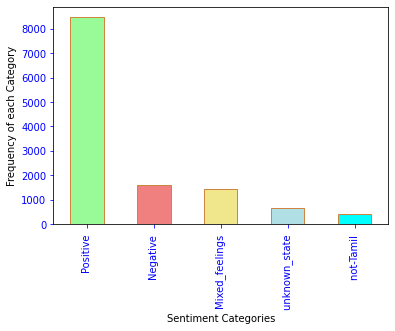

In [30]:
counter = Counter(label_)
print(counter)

plt.ylabel('Frequency of each Category')
plt.xlabel('Sentiment Categories')

s = pd.Series(list(counter.values()), index = list(counter.keys()) )

ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='blue')

s.plot.bar(color=['palegreen', 'lightcoral', 'khaki', 'powderblue', 'cyan'], edgecolor='peru')
plt.savefig('Tamil_class.jpg', dpi=300)
plt.plot()
# plt.show()

In [31]:

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    max_features=10000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=30000)


In [32]:
# build Vocabulary and Transform raw input to features
word_vectorizer.fit(text_)
char_vectorizer.fit(text_)

# word_vectorizer.fit(all_text)
# char_vectorizer.fit(all_text)


def feature_conversion(trainX):
  train_word_feat = word_vectorizer.transform(trainX)
  train_char_feat = char_vectorizer.transform(trainX)
  return hstack([train_word_feat, train_char_feat])


In [34]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split


# X_train = train_text
# X_test = dev_text

# y_train = train_label
# y_test = dev_label

X_train = feature_conversion(text_)

def Classifier1():
  steps = [('model',LogisticRegression())]
  pipeline = Pipeline(steps=steps)
  return pipeline

# def Classifier2():
#   steps = [('model',LogisticRegression(class_weight='balanced'))]
#   pipeline = Pipeline(steps=steps)
#   return pipeline

# def Classifier3():
#   steps = [('under',TomekLinks()),('model',LogisticRegression())]
#   pipeline = Pipeline(steps=steps)
#   return pipeline

# def Classifier4():
#   steps = [('under',TomekLinks()),('model',LogisticRegression(class_weight='balanced'))]
#   pipeline = Pipeline(steps=steps)
#   return pipeline

train_x, dev_x, train_y, dev_y = train_test_split(X_train, label_, test_size=0.1, shuffle=True)

classifier1 = Classifier1()
classifier1.fit(train_x, train_y)

dev_predict1 = classifier1.predict(dev_x)

cm = confusion_matrix(dev_y, dev_predict1)
print(classification_report(dev_y, dev_predict1, digits=4))
print(accuracy_score(dev_y, dev_predict1))
print(cm)

# columns = index = label_.unique()
# cm_df = pd.DataFrame(cm, columns, index)                  
# plt.figure(figsize=(10,6))
# sns.heatmap(cm_df, annot=True)
# plt.savefig('tamil_heatmap.jpg')
# plt.plot()

# classifier2 = Classifier2()
# classifier2.fit(train_x, train_y)

# dev_predict2 = classifier2.predict(dev_x)

# cm = confusion_matrix(dev_y, dev_predict2)
# print(classification_report(dev_y, dev_predict2, digits=4))
# print(accuracy_score(dev_y, dev_predict2))
# print(cm)


# classifier3 = Classifier3()
# classifier3.fit(train_x, train_y)

# dev_predict3 = classifier3.predict(dev_x)

# cm = confusion_matrix(dev_y, dev_predict3)
# print(classification_report(dev_y, dev_predict3, digits=4))
# print(accuracy_score(dev_y, dev_predict3))
# print(cm)


# classifier4 = Classifier4()
# classifier4.fit(train_x, train_y)

# dev_predict4 = classifier4.predict(dev_x)

# cm = confusion_matrix(dev_y, dev_predict4)
# print(classification_report(dev_y, dev_predict4, digits=4))
# print(accuracy_score(dev_y, dev_predict4))
# print(cm)


                 precision    recall  f1-score   support

Mixed_feelings      0.3684    0.0458    0.0814       153
      Negative      0.4697    0.2183    0.2981       142
      Positive      0.7361    0.9599    0.8333       872
     not-Tamil      0.8261    0.5429    0.6552        35
 unknown_state      0.3333    0.0862    0.1370        58

       accuracy                         0.7135      1260
      macro avg     0.5467    0.3706    0.4010      1260
   weighted avg     0.6454    0.7135    0.6446      1260

0.7134920634920635
[[  7  15 130   1   0]
 [  3  31 104   1   3]
 [  9  18 837   1   7]
 [  0   1  15  19   0]
 [  0   1  51   1   5]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [36]:
test_data = pd.read_csv('data/tamil_test.csv', encoding='utf-8', sep=',')

test_data.columns
test_id = test_data['id']
test_text = test_data['text']

if cleaning:
  test_text = test_text.apply(lambda x: p.clean(x))
  test_feat = feature_conversion(test_text)
else:
  test_feat = feature_conversion(test_text)

test_pred_label = classifier1.predict(test_feat)
test_label = pd.DataFrame(test_pred_label, index=None, columns=['label'])
pd.concat([test_id, test_data['text'], test_label], axis=1).to_csv('tamil_test_pred.tsv', sep='\t', index=False)


In [14]:
# # from sklearn.model_selection import GridSearchCV
# # parameters = {'booster':('gbtree', 'gblinear', 'dart'), 'max_depth':[3, 4, 5]}
# # xgb = XGBClassifier()
# # clf = GridSearchCV(xgb, parameters, cv=10, verbose=10)
# # clf.fit(train_x, train_label)


# # xgb = XGBClassifier(booster='gbtree', max_depth=5)
# xgb = LogisticRegression(class_weight='balanced')

# # xgb = CatBoostClassifier(verbose=0, n_estimators=100)
# xgb.fit(train_x, train_label)

# # xgb1 = XGBClassifier(booster='dart', max_depth=5)
# # xgb1.fit(train_x, train_label)

In [15]:
# dev_predict = xgb.predict(dev_x)

# cm = confusion_matrix(dev_label, dev_predict)
# print(cm)
# columns = index = train_label.unique()

# cm_df = pd.DataFrame(cm, columns, index)                  
# plt.figure(figsize=(10,6))
# sns.heatmap(cm_df, annot=True)
# plt.savefig('heatmap.jpg')

# print(classification_report(dev_label, dev_predict, digits=4))
# print(accuracy_score(dev_label, dev_predict))


# ** *This cell is testing cell, used for applying stratified cross validation to avoid imbalancing issues.* **

In [16]:
#

# from sklearn.model_selection import StratifiedKFold
# from sklearn import preprocessing
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# # from catboost import CatBoostClassifier


# le = preprocessing.LabelEncoder()

# x_data, y_data = train_text.to_list()+dev_text.to_list(), train_label.to_list()+dev_label.to_list()
# x_idx = [idx for idx, _ in enumerate(x_data)]
# le.fit(y_data)
# y_idx = le.transform(y_data)

# skf = StratifiedKFold(n_splits=10)


# for train_index, test_index in skf.split(x_idx, y_idx):
#   X_train = [x_data[x_idx[idx]] for idx in train_index]
#   X_test = [x_data[x_idx[idx]] for idx in test_index]

#   y_train = [list(le.inverse_transform([y_idx[idx]]))[0] for idx in train_index]
#   y_test = [list(le.inverse_transform([y_idx[idx]]))[0] for idx in test_index]

#   train_word_feat = word_vectorizer.transform(X_train)
#   train_char_feat = char_vectorizer.transform(X_train)

#   test_word_feat = word_vectorizer.transform(X_test)
#   test_char_feat = char_vectorizer.transform(X_test)

#   X_train = hstack([train_word_feat, train_char_feat])
#   X_test = hstack([test_word_feat, test_char_feat])

#  # class weight parameters work well for Malayalam LR model, rather than Tamil LR model-- class_weight='balanced'
#   lr = LogisticRegression()
#   # lr = xgb = CatBoostClassifier(verbose=0, n_estimators=100)
#   # lr = xgb = XGBClassifier(booster='gbtree', max_depth=5)

  
  
#   lr.fit(X_train, y_train)

#   dev_predict = lr.predict(X_test)

#   cm = confusion_matrix(y_test, dev_predict)
#   print(cm)
#   # columns = index = train_label.unique()

#   # cm_df = pd.DataFrame(cm, columns, index)                  
#   # plt.figure(figsize=(10,6))
#   # sns.heatmap(cm_df, annot=True)
#   # plt.savefig('heatmap.jpg')

#   print(classification_report(y_test, dev_predict, digits=4))
#   print(accuracy_score(y_test, dev_predict))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[ 12  12 116   1   2]
 [  4  28 126   1   2]
 [  9  14 815   5   6]
 [  0   1  17  22   0]
 [  0   4  54   1   8]]
                 precision    recall  f1-score   support

Mixed_feelings      0.4800    0.0839    0.1429       143
      Negative      0.4746    0.1739    0.2545       161
      Positive      0.7225    0.9600    0.8245       849
     not-Tamil      0.7333    0.5500    0.6286        40
 unknown_state      0.4444    0.1194    0.1882        67

       accuracy                         0.7024      1260
      macro avg     0.5710    0.3774    0.4077      1260
   weighted avg     0.6489    0.7024    0.6342      1260

0.7023809523809523


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  6  11 123   1   1]
 [  4  44 109   2   2]
 [  7  15 816   7   4]
 [  1   0  18  21   0]
 [  1   1  64   0   2]]
                 precision    recall  f1-score   support

Mixed_feelings      0.3158    0.0423    0.0745       142
      Negative      0.6197    0.2733    0.3793       161
      Positive      0.7221    0.9611    0.8247       849
     not-Tamil      0.6774    0.5250    0.5915        40
 unknown_state      0.2222    0.0294    0.0519        68

       accuracy                         0.7056      1260
      macro avg     0.5115    0.3662    0.3844      1260
   weighted avg     0.6348    0.7056    0.6341      1260

0.7055555555555556


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  9   9 123   1   0]
 [  3  36 116   4   2]
 [  7  26 808   4   4]
 [  1   0  21  18   0]
 [  0   5  54   0   9]]
                 precision    recall  f1-score   support

Mixed_feelings      0.4500    0.0634    0.1111       142
      Negative      0.4737    0.2236    0.3038       161
      Positive      0.7201    0.9517    0.8199       849
     not-Tamil      0.6667    0.4500    0.5373        40
 unknown_state      0.6000    0.1324    0.2169        68

       accuracy                         0.6984      1260
      macro avg     0.5821    0.3642    0.3978      1260
   weighted avg     0.6500    0.6984    0.6326      1260

0.6984126984126984


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  7  11 123   0   1]
 [  6  31 124   0   0]
 [  9  23 810   1   6]
 [  0   1  19  20   0]
 [  2   5  54   0   7]]
                 precision    recall  f1-score   support

Mixed_feelings      0.2917    0.0493    0.0843       142
      Negative      0.4366    0.1925    0.2672       161
      Positive      0.7168    0.9541    0.8186       849
     not-Tamil      0.9524    0.5000    0.6557        40
 unknown_state      0.5000    0.1029    0.1707        68

       accuracy                         0.6944      1260
      macro avg     0.5795    0.3598    0.3993      1260
   weighted avg     0.6289    0.6944    0.6253      1260

0.6944444444444444


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  7   9 125   0   1]
 [  4  33 121   2   2]
 [ 10  23 807   5   3]
 [  0   4  18  18   0]
 [  0   5  56   3   4]]
                 precision    recall  f1-score   support

Mixed_feelings      0.3333    0.0493    0.0859       142
      Negative      0.4459    0.2037    0.2797       162
      Positive      0.7161    0.9517    0.8172       848
     not-Tamil      0.6429    0.4500    0.5294        40
 unknown_state      0.4000    0.0588    0.1026        68

       accuracy                         0.6897      1260
      macro avg     0.5076    0.3427    0.3629      1260
   weighted avg     0.6188    0.6897    0.6180      1260

0.6896825396825397


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  9  16 116   0   1]
 [  5  36 117   2   2]
 [  6  27 809   0   6]
 [  0   1  15  23   0]
 [  2   6  50   2   8]]
                 precision    recall  f1-score   support

Mixed_feelings      0.4091    0.0634    0.1098       142
      Negative      0.4186    0.2222    0.2903       162
      Positive      0.7308    0.9540    0.8276       848
     not-Tamil      0.8519    0.5897    0.6970        39
 unknown_state      0.4706    0.1176    0.1882        68

       accuracy                         0.7029      1259
      macro avg     0.5762    0.3894    0.4226      1259
   weighted avg     0.6440    0.7029    0.6389      1259

0.7029388403494837


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[ 10  10 121   0   1]
 [  4  28 124   2   4]
 [  6  25 808   3   6]
 [  0   1  17  21   0]
 [  1   5  58   0   4]]
                 precision    recall  f1-score   support

Mixed_feelings      0.4762    0.0704    0.1227       142
      Negative      0.4058    0.1728    0.2424       162
      Positive      0.7163    0.9528    0.8178       848
     not-Tamil      0.8077    0.5385    0.6462        39
 unknown_state      0.2667    0.0588    0.0964        68

       accuracy                         0.6918      1259
      macro avg     0.5345    0.3587    0.3851      1259
   weighted avg     0.6278    0.6918    0.6211      1259

0.6918189038919778


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  5   8 129   0   1]
 [  7  38 114   0   2]
 [  6  18 818   3   3]
 [  0   0  16  23   0]
 [  3   3  57   0   5]]
                 precision    recall  f1-score   support

Mixed_feelings      0.2381    0.0350    0.0610       143
      Negative      0.5672    0.2360    0.3333       161
      Positive      0.7213    0.9646    0.8254       848
     not-Tamil      0.8846    0.5897    0.7077        39
 unknown_state      0.4545    0.0735    0.1266        68

       accuracy                         0.7061      1259
      macro avg     0.5732    0.3798    0.4108      1259
   weighted avg     0.6374    0.7061    0.6343      1259

0.7061159650516283


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  7  19 113   3   1]
 [  3  36 119   1   2]
 [  8  16 815   6   3]
 [  0   1  17  22   0]
 [  0   5  55   1   6]]
                 precision    recall  f1-score   support

Mixed_feelings      0.3889    0.0490    0.0870       143
      Negative      0.4675    0.2236    0.3025       161
      Positive      0.7283    0.9611    0.8287       848
     not-Tamil      0.6667    0.5500    0.6027        40
 unknown_state      0.5000    0.0896    0.1519        67

       accuracy                         0.7037      1259
      macro avg     0.5503    0.3746    0.3946      1259
   weighted avg     0.6423    0.7037    0.6339      1259

0.7037331215250199
[[  5   6 128   2   2]
 [  2  37 122   0   0]
 [  8  18 816   1   5]
 [  0   1  16  23   0]
 [  0   5  54   0   8]]
                 precision    recall  f1-score   support

Mixed_feelings      0.3333    0.0350    0.0633       143
      Negative      0.5522    0.2298    0.3246       161
      Positive      0.7183    0.9623    0.8226       848
    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
